

Tutorial for using 

## Introduction

In this notebook, we'll implement a Markov Chain Monte Carlo (MCMC) algorithm and demonstrate its use on two realistic simulated datasets. First, we'll fit a line to a set of data points with Gaussian uncertainties in one dimension. This problem should *never* be done using MCMC in practice—the solution is analytic!—but it is useful as a functional test of the code and as a demonstration of the concepts. Next, we'll fit a power law model to a set of entries in a catalog assuming a Poisson likelihood function. This problem is very relevant to this meeting for a few reasons but we'll come back to that later.

This worksheet is written in Python and it lives in an IPython notebook. In this context, you'll be asked to write a few lines of code to implement the sampler and the models but much of the boilerplate code is already in place. Therefore, even if you're not familiar with Python, you should be able to get something out of the notebook. I don't expect that everyone will finish the full notebook but that's fine because it has been designed to get more difficult as we progress.

## How to use the notebook

*If you're familiar with IPython notebooks, you can probably skip this section without missing anything.*

IPython notebooks work by running a fully functional Python sever behind the scenes and if you're reading this then you probably already figured out how to get that running. Then, inside the notebook, the content is divided into cells containing code or text.

You'll be asked to edit a few of the cells below to add your own code. To do this, click on the cell to start editing and then type as you normally would. To execute the code contained in the cell, press `Shift-Enter`. Even for existing cells that you don't need to edit, you should select them and type `Shift-Enter` when you get there because the cells below generally depend on the previous cells being executed first.

To get started, edit the cell below to assign your name (or whatever you want) to the variable `name` and then press `Shift-Enter` to exectue the cell.

# Fast Bayesian Regression in Python using Numba

by **Aditya Pandya**

Welcome to the "Fast Bayesian Regression" tutorial! In this Jupyter Notebook, you will explore the fundamentals of Bayesian regression and learn how to perform it efficiently using Python. I have also provide a tutorial for using the package [FBR.py](). 

In this tutorial, we will cover the following key topics:

1. **Introduction to Bayesian Regression**: I'll start by providing an overview of what Bayesian regression is, its advantages, and when it's most useful in comparison to other regression techniques.

2. **Installation and Setup**: Before diving into the code, make sure that you have the necessary libraries and dependencies installed. 

3. **Data Preparation**: Data is at the heart of any regression analysis.  You will learn how to load, preprocess, and visualize our data, as this is a crucial step in any regression analysis.

4. **Bayesian Linear Regression**: We'll introduce the concept of Bayesian linear regression and explain how it differs from traditional linear regression. You'll learn about the prior and posterior distributions and how to estimate model parameters using Bayesian techniques.

5. **Fast Bayesian Regression**: The focus of this tutorial is on making Bayesian regression computationally efficient. We will introduce you to the concept of fast Bayesian regression and discuss techniques for speeding up the inference process.

6. **Comparision with and without Numba**: Numba is a tool that helps in making the cutting down the processing time and makes the code faster for multiple use.

7. **How to use FBR.py**: Tutorial for how to use the contents of the file FBR.py which lets you perform fast bayesian regression

7. **Bonus: How to make your code faster**: To solidify your understanding, we will walk through how one can use Numba and python profiling to understand your code and make it faster.



Let's get started! If you haven't already, make sure you have the "Fast Bayesian Regression" repository cloned or downloaded from [here](https://github.com/AdiPandya/Fast_Bayesian_Regression). 

In [118]:
name = "YOUR NAME HERE"
print("Hello {0}!".format(name))

Hello YOUR NAME HERE!


If this works, the output should greet you without throwing any errors. If so, that's pretty much all we need so let's get started with some MCMC!

## Dataset 1: Fitting a line to data

Today, we're going to implement the simplest possible MCMC algorithm but before we do that, we'll need some data to test our method with.

### Load the data

I've generated a simulated dataset generated from a linear model with no uncertainties in the $x$ dimension and known Gaussian uncertainties in the $y$ dimension. These data are saved in the CSV file `linear.csv` included with this notebook.

First we'll need `numpy` and `matplotlib` so let's import them:

In [119]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100  # This makes all the plots a little bigger.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now we'll load the datapoints and plot them. When you execute the following cell, you should see a plot of the data. If not, make sure that you run the import cell from above first.

In [120]:
df = pd.read_csv("5_outliers_JK_reduced.csv")

xdata=np.log10(df['T'])
ydata=np.log10(df['MCCD_sigma_los'])

median_T = 5.5
median_V = 750

Tdata_N=np.array(np.log10(df['T']/median_T))
errT=np.array(np.log10(np.e)*(df['E_T']+df['e_t_lc'])/(2*df['T']))
Vdata_N=np.array(np.log10(df['MCCD_sigma_los']/median_V))
errV=np.array(np.log10(np.e)*df['MCCD_e_sigma_los_stand']/df['MCCD_sigma_los'])# Load the data from the CSV file.

x,y,xerr,yerr = Tdata_N, Vdata_N, errT, errV

We'll save these results for later to compare them to the result computed using MCMC but for now, it's nice to take a look and see what this prediction looks like. To do this, we'll sample 24 slopes and intercepts from this 2d Gaussian and overplot them on the data.

This plot is a visualization of our posterior expectations for the *true* underlying line that generated these data. We'll reuse this plot a few times later to test the results of our code.

### The probabilistic model

In order use MCMC to perform posterior inference on a model and dataset, we need a function that computes the value of the posterior probability given a proposed setting of the parameters of the model. For reasons that will become clear below, we actually only need to return a value that is *proportional* to the probability.

As discussed in a previous tutorial, the posterior probability for parameters $\mathbf{w} = (m,\,b)$ conditioned on a dataset $\mathbf{y}$ is given by

$$p(\mathbf{w} \,|\, \mathbf{y}) = \frac{p(\mathbf{y} \,|\, \mathbf{w}) \, p(\mathbf{w})}{p(\mathbf{y})}$$

where $p(\mathbf{y} \,|\, \mathbf{w})$ is the *likelihood* and $p(\mathbf{w})$ is the *prior*. For this example, we're modeling the likelihood by assuming that the datapoints are independent with known Gaussian uncertainties $\sigma_n$. This specifies a likelihood function:

$$p(\mathbf{y} \,|\, \mathbf{w}) = \prod_{n=1}^N \frac{1}{\sqrt{2\,\pi\,\sigma_n^2}} \,
\exp \left(-\frac{[y_n - f_\mathbf{w}(x_n)]^2}{2\,\sigma_n^2}\right)$$

where $f_\mathbf{w}(x) = m\,x + b$ is the linear model.

For numerical reasons, we will acutally want to compute the logarithm of the likelihood. In this case, this becomes:

$$\ln p(\mathbf{y} \,|\, \mathbf{w}) = -\frac{1}{2}\sum_{n=1}^N \left(\frac{[y_n - f_\mathbf{w}(x_n)]^2}{\sigma_n^2} + \ln(2\pi\sigma_n^2)\right) \quad.$$

In the following cell, replace the contents of the `lnlike_linear` function to implement this model. The function takes two values (`m` and `b`) as input and it should return the log likelihood (a single number) up to a constant. In this function, you can just use the globaly defined dataset `x`, `y` and `yerr`. For performance, I recommend using vectorized numpy operations (the key function will be `np.sum`).

In [121]:
def lnlike_linear(param):
    m,b, si = param[0], param[1], param[2]
    f = m*x + b
    sigma = np.sqrt((yerr**2) + np.square(m * xerr)+ (si**2))
    return -0.5 * np.sum((((y-f) / sigma) ** 2)+ np.log(2*np.pi*(sigma**2)))

In [122]:
lnlike_linear((0.4,0.03, 0.01)),lnlike_linear((1,1,5))

(15.917912491342687, -399.8590367871497)

After you're satisfied with your implementation, run the following cell. In this cell, we're checking to see if your code is right. If it is, you'll see a smiling face (☺︎) but if not, you'll get an error message.

If you don't get the ☺︎, go back and try to debug your model. Iterate until your result is correct.

Once you get that, we'll use this to implement the full model (*Remember: we haven't added in the prior yet*). For the purposes of this demonstration, we'll assume broad uniform priors on both $m$ and $b$. This isn't generally a good idea... instead, you should normally use a prior *that actually represents your prior beliefs*. But this a discussion for another day.

I've chosen to set the bounds on each parameter to be (-10, 10) but you should feel free to change these numbers. Since this is the log-prior, we'll return `-np.inf` from `lnprior_linear` when the parameter is outside of the allowed range. And then, since we only need to compute the probability up to a constant, we will return `0.0` (an arbitrary constant) when the parameters are valid.

Finally, the function `lnpost_linear` sums the output of `lnprior_linear` and `lnlike_linear` to compute the log-posterior probability up to a constant.

In [123]:
def lnprior_linear(param):
    m,b,sig = param[0], param[1], param[2]
    if not (-10 < m < 10):
        return -np.inf
    if not (-10 < b < 10):
        return -np.inf
    if not (0 < sig < 10):
        return -np.inf
    return 0.0

def lnpost_linear(theta):
    return lnprior_linear(theta) + lnlike_linear(theta)

### Metropolis(–Hastings) MCMC

The simplest MCMC algorithm is generally referred to as the Metropolis method. All MCMC algorithms work by specifying a "step" that moves from one position in parameter space to another with some probability. The Metropolis step takes a position $\theta_t$ (a vector containing the slope and intercept at step $t$) to the position $\theta_{t+1}$ using the following steps:

1. propose a new position $\mathbf{q}$ drawn from a Gaussian centered on the current position $\theta_t$
2. compute the probability of the new position $p(\mathbf{q}\,|\,\mathbf{y})$
3. draw a random number $r$ between 0 and 1 and if
$$r < \frac{p(\mathbf{q}\,|\,\mathbf{y})}{p(\mathbf{x}_t\,|\,\mathbf{y})}$$
return $\mathbf{q}$ as $\theta_{t+1}$ and, otherwise, return $\theta_t$ as $\theta_{t+1}$.

In the following cell, you'll implement this step. The function will take 4 arguments:

1. a function that computes the ln-probability (for this demo, it'll be `lnpost_linear` from above),
2. the current position $\theta_t$,
3. the ln-probability at the current point $p(\theta_t\,|\,\mathbf{y})$, and
4. the covariance matrix of the Gaussian proposal distribution.

It should return two values, the new coordinate $\theta_{t+1}$ and the ln-probability at that point $p(\theta_{t+1}\,|\,\mathbf{y})$. The syntax for returning multiple values is `return a, b`.

This function is really the key to this whole tutorial so spend some time getting it right! It is hard to robustly test functions with a random component so chat with other people around you to check your method. We'll also try to test it below but it's worth spending some time now.

There are a few functions that will come in handy here but the two most important ones are:

- `np.random.multivariate_normal(theta_t, step_cov)` - draws a vector sample from the multivariate Gaussian centered on `theta_t` with covariance matrix `step_cov`.
- `np.random.rand()` - draws a random number between 0 and 1.

In [124]:
np.random.rand()

0.3457054110443163

In [125]:
def metropolis_step(lnpost_function, theta_t, lnpost_t, step_cov):
    # CODE HERE
    q = np.random.multivariate_normal(theta_t, step_cov)
    lp1 = lnpost_function(q)
    if lp1 - lnpost_t > np.log(np.random.rand()):
        return q, lp1
    return theta_t, lnpost_t

As before, here's a simple test for this function. When you run the following cell it will either print a smile or throw an exception. Since the algorithm is random, it might occasionally fail this test so if it fails once, try running it again. If it fails a second time, edit your implementation until the test consistently passes.

### Running the Markov Chain

Now that we have an implementation of the Metropolis step, we can go on to sample from the posterior probability density that we implemented above. To start, we need to initialize the sampler somewhere in parameter space. In the following cell, edit your guess for the slope and intercept of the line until it looks like a rasonably good fit to the data.

In the next cell, we'll start from this initial guess for the slope and intercept and walk through parameter space (using the transition probability from above) to generate a Markov Chain of samples from the posterior probability.

There are a few tuning parameters for the method. The first and most important choice has already been covered: **initialization**. The practical performance of an MCMC sampler depends sensitively on the initial position so it's worth spending some time choosing a good initialization.

The second big tuning parameter is **the scale of the proposal distribution**. We must specify the covariance matrix for the proposal Gaussian. This proposal is currently set to a very bad value. Your job is to run the sampler, look at the output, and try to tune the proposal until you find a "good" value. You will judge this based on a few things. First, you can check the acceptance fraction (the fraction of accepted proposals). For this (easy!) problem, the target is around about 50% but for harder problems in higher dimensions, a good target is around 20%. Another useful diagnostic is a plot of the parameter values as a function of step number. For example, if this looks like a random walk then your proposal scale is probably too small. Once you reach a good proposal, this plot should "look converged".

The final tuning parameter is **the number of steps to take**. In theory, you need to take an infitite number of steps but we don't (ever) have time for that so instead you'll want to take a large enough number of samples so that the sampler has sufficiently explored parameter space and converged to a stationary distribution. This is, of course, unknowable so for today you'll just have to go with your intuition.

You can also change the number of steps that are discarded as burn-in but (in this problem) your results shouldn't be very sensitive to this number.

Take some time now to adjust these tuning parameters and get a sense of what happens to the sampling when you change different things.

The acceptance fraction was: 0.253


Text(0.5, 0, 'step number')

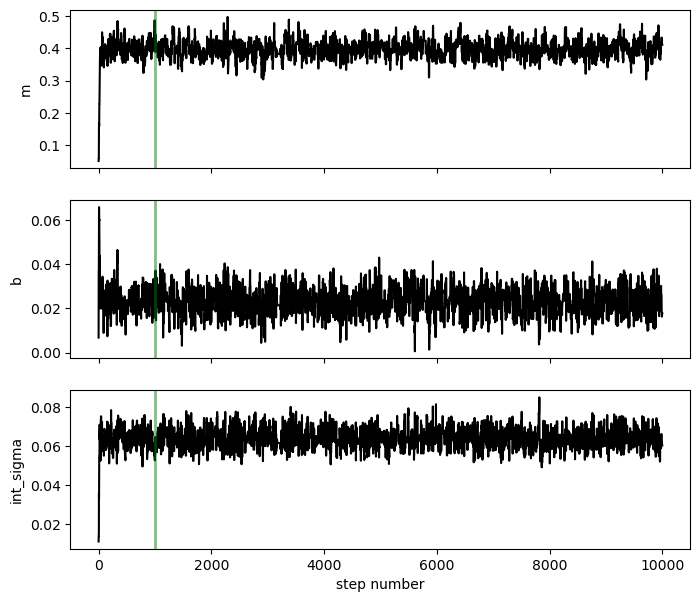

In [126]:
# Edit this line to specify the proposal covariance:
step = np.diag([1e-3, 1e-4, 1e-4])

# Edit this line to choose the number of steps you want to take:
nstep = 20000

# Edit this line to set the number steps to discard as burn-in.
nburn = 2000

# You shouldn't need to change any of the lines below here.
p0 = np.array([0, 0, 0])
lp0 = lnpost_linear(p0)
chain = np.empty((nstep, len(p0)))
for i in range(len(chain)):
    p0, lp0 = metropolis_step(lnpost_linear, p0, lp0, step)
    chain[i] = p0
    
# Compute the acceptance fraction.
acc = float(np.any(np.diff(chain, axis=0), axis=1).sum()) / (len(chain)-1)
print("The acceptance fraction was: {0:.3f}".format(acc))

# Plot the traces.
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
axes[0].plot(chain[:, 0], "k")
axes[0].set_ylabel("m")
axes[0].axvline(nburn, color="g", alpha=0.5, lw=2)

axes[1].plot(chain[:, 1], "k")
axes[1].set_ylabel("b")
axes[1].axvline(nburn, color="g", alpha=0.5, lw=2)

axes[2].plot(chain[:, 2], "k")
axes[2].set_ylabel("int_sigma")
axes[2].axvline(nburn, color="g", alpha=0.5, lw=2)

axes[2].set_xlabel("step number")
#axes[0].set_title("acceptance: {0:.3f}".format(acc));

In [57]:
chain.shape

(10000, 3)

In [127]:
chain[500:,0].mean(), chain[500:,1].mean()

(0.3979070445578368, 0.023190874747971827)

(array([   2.,    6.,   21.,   18.,   31.,   58.,  132.,  172.,  289.,
         404.,  572.,  828.,  992.,  992., 1013.,  982.,  846.,  746.,
         603.,  342.,  242.,  108.,   73.,   21.,    7.]),
 array([-0.00076481,  0.00089284,  0.00255049,  0.00420814,  0.00586579,
         0.00752344,  0.0091811 ,  0.01083875,  0.0124964 ,  0.01415405,
         0.0158117 ,  0.01746935,  0.019127  ,  0.02078465,  0.0224423 ,
         0.02409995,  0.0257576 ,  0.02741525,  0.0290729 ,  0.03073055,
         0.03238821,  0.03404586,  0.03570351,  0.03736116,  0.03901881,
         0.04067646]),
 <BarContainer object of 25 artists>)

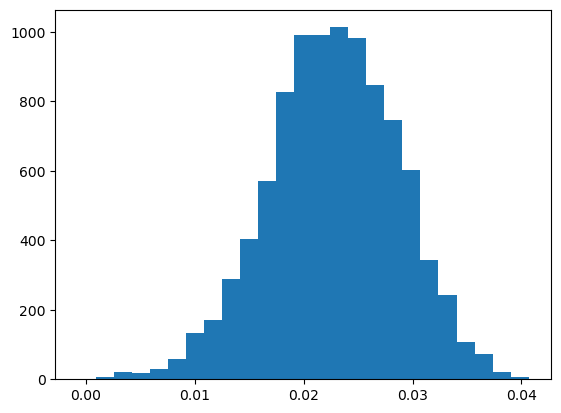

In [59]:
plt.hist(chain[500:,1], bins=25)

The results of the MCMC run are stored in the array called `chain` with dimensions `(nstep, 2)`. These are samples from the posterior probability density for the parameters. We know from above that this should be a Gaussian with mean $\mathbf{w}$ and covariance $\mathbf{V}$ so let's compare the sample mean and covariance to the analytic result that we computed above:

If you don't get a smile here, that could mean a few things:

- you didn't run for long enough (try increasing `nstep`),
- your choice of step scale was not good (try playing around with the definition of `step`), or
- there's a bug in your code.

Try out all of these tuning parameters until you have a good intuition for what's going on and figure out which settings pass this test and which don't.

### Plotting the results

In this section, we'll make two plots that are very useful for checking your results after you run an MCMC:

1. **corner plot** or **scatterplot matrix** — a plot of all the 2- and 1-D projections of the MCMC samples. To make this plot, we'll use [triangle.py](https://github.com/dfm/triangle.py), a Python module specifically designed for this purpose. For simplicity, I've included the module with this notebook so you won't have to install it separately.

2. **predictive distribution** — a plot of the "posterior predicted data" overplotted on the observed data. This kind of plot can be used as a qualitative model check.

First, the corner plot:

This plot is a representation of our contraints on the posterior probability for the slope and intercept conditioned on the data. The 2-D plot shows the full posterior and the two 1-D plots show the constraints for each parameter marginalized over the other.

The second plot that we want to make is a represnetation of the posterior predictive distribution for the data. To do this we will plot a few (50) randomly selected samples from the chain and overplot the resulting line on the data.

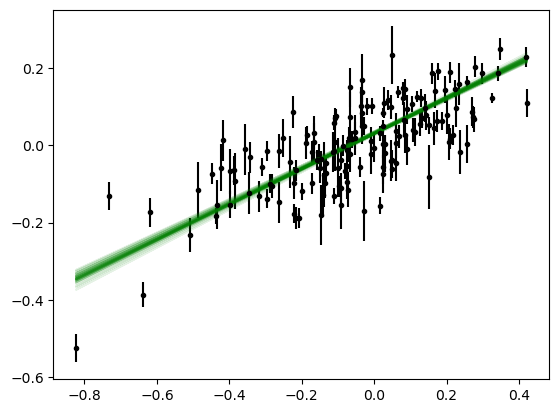

In [19]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
for m, b in chain[nburn+np.random.randint(len(chain)-nburn, size=50)]:
    plt.plot(x, m*x + b, "g", alpha=0.1)

It is always useful to make a plot like this because it lets you see if your model is capable of describing your data or if there is anything catasrophically wrong.


## Dataset 2: Population inference

In this section, we'll go through a more realistic example problem. There is not closed form solution for the posterior probability in this case and the model might even be relevant to your research! In this problem, we're using a simulated catalog of measurements and we want to fit for a power law rate function. This is similar to how you might go about fitting for the luminosity function of a population of stars for example.

A (wrong!) method that is sometimes used for this problem is to make a histogram of the samples and then fit a line to the log bin heights but the correct method is not much more complicated than this. Instead, we start by choosing a rate model that (in this case) will be a power law:

$$\Gamma(x) = \alpha\,x^{\beta} \quad \mathrm{for} \, a < x < b$$

and we want to find the posterior probability for $\alpha$ and $\beta$ conditioned on a set of measurements $\{x_k\}_{k=1}^K$. To do this, we need to choose a likelihood function (a generative model for the dataset). A reasonable choice in this case is the likelihood function for an *inhomogeneous Poisson process* (the generalization of the Poisson likelihood to a variable rate function):

$$p(\{x_k\}\,|\,\alpha,\,\beta) \propto \exp \left( - \int_a^b \Gamma(x)\,\mathrm{d}x \right) \, \prod_{k=1}^K \Gamma(x_k)$$

Because of our choice of rate function, we can easily compute the integral in the exponent:

$$\int_a^b \Gamma(x)\,\mathrm{d}x = \frac{\alpha}{\beta+1}\,\left[b^{\beta+1} - a^{\beta+1}\right]$$

Therefore, the full log-likelihood function is:

$$\ln p(\{x_k\}\,|\,\alpha,\,\beta) = \frac{\alpha}{\beta+1}\,\left[a^{\beta+1} - b^{\beta+1}\right] + K\,\ln\alpha + \sum_{k=1}^K \beta\,\ln x_k + \mathrm{const}$$

In the next few cell, you'll implement this model and use your MCMC implementation from above to sample from the posterior for $\alpha$ and $\beta$. But first, let's load the data and plot it.

In this cell, you should change your initial guess for `alpha` and `beta` until the green line gives a good fit to the histogram.

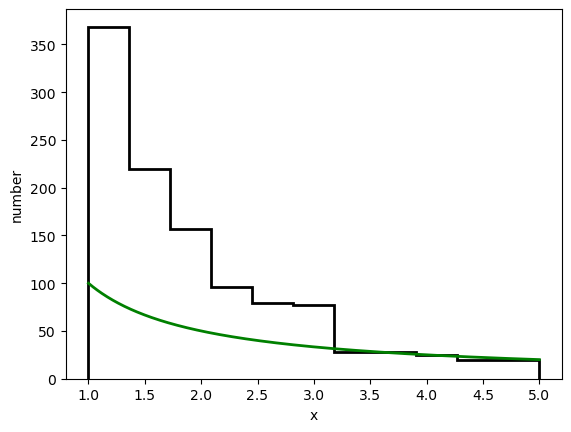

In [70]:
# Edit these guesses.
alpha_initial = 100
beta_initial = -1

# These are the edges of the distribution (don't change this).
a, b = 1.0, 5.0

# Load the data.
events = np.loadtxt("poisson.csv")

# Make a correctly normalized histogram of the samples.
bins = np.linspace(a, b, 12)
weights = 1.0 / (bins[1] - bins[0]) + np.zeros(len(events))
plt.hist(events, bins, range=(a, b), histtype="step", color="k", lw=2, weights=weights)
    
# Plot the guess at the rate.
xx = np.linspace(a, b, 500)
plt.plot(xx, alpha_initial * xx ** beta_initial, "g", lw=2)

# Format the figure.
plt.ylabel("number")
plt.xlabel("x");

In the following cell, you need to implement the log-likelihood function for the problem (same as above):

$$\ln p(\{x_k\}\,|\,\alpha,\,\beta) = \frac{\alpha}{\beta+1}\,\left[a^{\beta+1} - b^{\beta+1}\right] + K\,\ln\alpha + \sum_{k=1}^K \beta\,\ln x_k + \mathrm{const}$$

Note that this is only valid for $\beta \ne -1$. In practice you shouldn't ever hit this boundary but, just in case,  you should special case `beta == 1.0` where

$$\ln p(\{x_k\}\,|\,\alpha,\,\beta=-1) = \alpha\,\left[\ln a - \ln b\right] + K\,\ln\alpha - \sum_{k=1}^K \ln x_k + \mathrm{const}$$

In [72]:
sme = np.sum(np.log(events))
K = len(events)
def lnlike_poisson(alpha, beta):
    if beta == -1.0:
        norm = alpha * (np.log(a) - np.log(b)) + K * np.log(alpha)
    else:
        bp1 = beta+1
        norm = alpha / bp1 * (a**bp1-b**bp1) + K * np.log(alpha)
    return norm + beta * sme

As before, edit your implementation until the following test passes.

In [74]:
p_1, p_2 = (1000.0, -1.), (1500., -2.)
ll_1, ll_2 = lnlike_poisson(1000.0, -1.), lnlike_poisson(1500., -2.)
if not np.allclose(ll_2 - ll_1, 337.039175916):
    raise ValueError("It looks like your implementation is wrong!")
print("☺︎")

☺︎


Once you're happy with this implementation, we'll define the full probabilistic model including a prior. As before, I've chosen a broad flat prior on `alpha` and `beta` but you should feel free to change this.

In [75]:
def lnprior_poisson(alpha, beta):
    if not (0 < alpha < 1000):
        return -np.inf
    if not (-10 < beta < 10):
        return -np.inf
    return 0.0

def lnpost_poisson(theta,theta2):
    return lnprior_poisson(theta,theta2) + lnlike_poisson(theta,theta2)

Now let's run the MCMC for this model. As before, you should tune the parameters of the algorithm until you get a reasonable acceptance fraction ($\sim 25- 40\%$) and the chains seem converged.

In [79]:
# Edit this line to specify the proposal covariance:
step = np.diag([100., 1e-1])

# Edit this line to choose the number of steps you want to take:
nstep = 50000

# Edit this line to set the number steps to discard as burn-in.
nburn = 1000

# You shouldn't need to change any of the lines below here.
#p0 = np.array(alpha_initial, beta_initial)
lp0 = lnpost_poisson(alpha_initial, beta_initial)
chain = np.empty((nstep, 2))
for i in range(len(chain)):
    p0, lp0 = metropolis_step(lnpost_poisson, p0, lp0, step)
    chain[i] = p0
    
# Compute the acceptance fraction.
acc = float(np.any(np.diff(chain, axis=0), axis=1).sum()) / (len(chain)-1)
print("The acceptance fraction was: {0:.3f}".format(acc))

# Plot the traces.
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
axes[0].plot(chain[:, 0], "k")
axes[0].set_ylabel("alpha")
axes[0].axvline(nburn, color="g", alpha=0.5, lw=2)
axes[1].plot(chain[:, 1], "k")
axes[1].set_ylabel("beta")
axes[1].axvline(nburn, color="g", alpha=0.5, lw=2)
axes[1].set_xlabel("step number")
axes[0].set_title("acceptance: {0:.3f}".format(acc));

NameError: name 'p0' is not defined

Once you're happy with to convergence of your chain, plot the results as a corner plot (compared to the values that I used to generate the dataset; $\alpha = 500$ and $\beta = -2$) and plot the posterior predictive distribution.

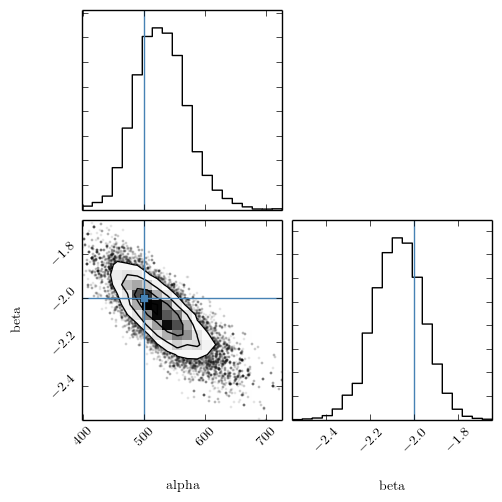

In [52]:
triangle.corner(chain[nburn:], labels=["alpha", "beta"], truths=[500, -2]);

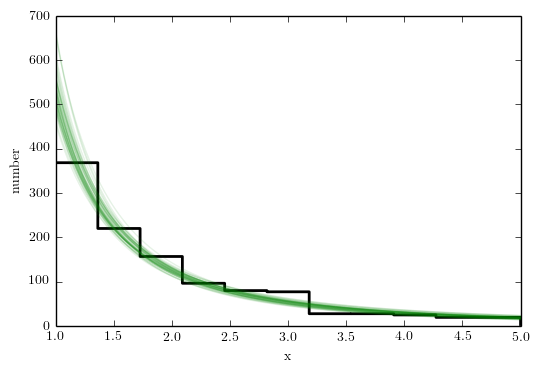

In [53]:
plt.hist(events, bins, range=(a, b), histtype="step", color="k", lw=2, weights=weights)
    
# Plot the guess at the rate.
xx = np.linspace(a, b, 500)
for alpha, beta in chain[nburn+np.random.randint(len(chain)-nburn, size=50)]:
    plt.plot(xx, alpha * xx ** beta, "g", alpha=0.1)

# Format the figure.
plt.ylabel("number")
plt.xlabel("x");

**Congratulations!** You have completed all the exercises that I have for you today. If you have extra time, you can try using your shiny new MCMC implementation on the model introduced by Bovy yesterday... or you can just head to happy hour.

The code that you've written today is now ready for prime time but I predict that once you start applying it to real (harder) problems with more parameters and more complicated posteriors, you'll find yourself frustrated at the tuning required to make the algorithm work. Instead, now that you have an intution for how MCMC works, I would recommend using an established implementation (like [emcee](http://dfm.io/emcee), for example) in your research problems.

There are quite a few things that we didn't have time to cover today but this should be enough to get you started. [The emcee paper](http://arxiv.org/abs/1202.3665) includes a lot of practical advice so that might be a place to start if you want to start using MCMC in your research. And here are a few questions to consider:

- How do you judge convergence of the chain quantitatively?
- How do you diagnose and troubleshoot issues with the sampling?
- What are some better ways of initializing the sampler?
- What numbers go into the abstract of the paper? Into the table of results?
- How should you share your results with the community?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eb74633e-b529-4c80-bf06-bcb14580caa8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>